# Prophet 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams["figure.figsize"] = (9,6)

## Basic forecasting with Prophet 

Source of data: https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [4]:
df = pd.read_csv('data/household_power_consumption.csv')
print(df.shape)
df.head()

(1000, 2)


,datetime,Global_active_power
0,2006-12-16 18:00:00,217.932
1,2006-12-16 19:00:00,204.014
2,2006-12-16 20:00:00,196.114
3,2006-12-16 21:00:00,183.388
4,2006-12-16 22:00:00,132.008


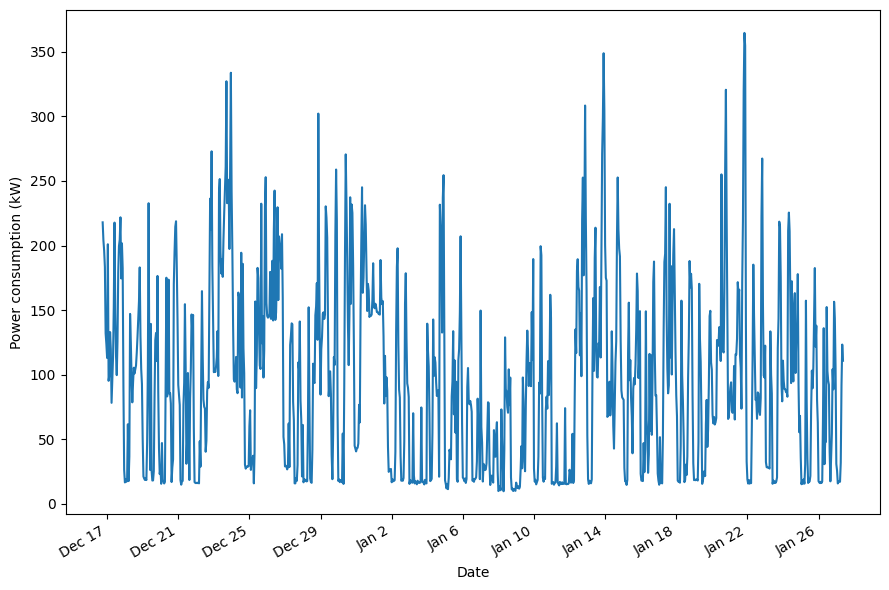

In [5]:
fig, ax = plt.subplots()

ax.plot(df['Global_active_power'])
ax.set_xlabel('Date')
ax.set_ylabel('Power consumption (kW)')

plt.xticks(np.arange(6, 999, 96), ['Dec 17', 'Dec 21', 'Dec 25', 'Dec 29', 'Jan 2', 'Jan 6', 'Jan 10', 'Jan 14', 'Jan 18', 'Jan 22', 'Jan 26'])

fig.autofmt_xdate()
plt.tight_layout()

### Rename columns appropriately 

In [6]:
# Rename the columns. The date column must be "ds" and the value column must be "y"
df.columns = ['ds', 'y']
df.head()


,ds,y
0,2006-12-16 18:00:00,217.932
1,2006-12-16 19:00:00,204.014
2,2006-12-16 20:00:00,196.114
3,2006-12-16 21:00:00,183.388
4,2006-12-16 22:00:00,132.008


### Train/test split 

In [7]:
# Keep the last 168 data points for the test set
train = df[:-168]
test = df[-168:]

### Initialize model and fit 

In [8]:
# Initialise model
m = Prophet()
m.fit(train)

13:36:42 - cmdstanpy - INFO - Chain [1] start processing
13:36:43 - cmdstanpy - INFO - Chain [1] done processing


### Make *future* DataFrame 

In [9]:
# Get furture df
future = m.make_future_dataframe(periods=168, freq='H')

### Forecast 

In [10]:
future.tail()

,ds
995,2007-01-27 05:00:00
996,2007-01-27 06:00:00
997,2007-01-27 07:00:00
998,2007-01-27 08:00:00
999,2007-01-27 09:00:00


In [11]:
# Make predictions
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
995,2007-01-27 05:00:00,114.831334,16.049403,171.532771,109.601087,119.426102,-18.090366,-18.090366,-18.090366,-45.433684,-45.433684,-45.433684,27.343318,27.343318,27.343318,0.0,0.0,0.0,96.740968
996,2007-01-27 06:00:00,114.924295,41.848151,191.043149,109.677336,119.586229,2.678245,2.678245,2.678245,-26.388445,-26.388445,-26.388445,29.066690,29.066690,29.066690,0.0,0.0,0.0,117.602539
997,2007-01-27 07:00:00,115.017255,77.773472,223.848164,109.749576,119.738611,31.310218,31.310218,31.310218,0.590197,0.590197,0.590197,30.720021,30.720021,30.720021,0.0,0.0,0.0,146.327473
998,2007-01-27 08:00:00,115.110215,98.296860,242.933230,109.805928,119.903276,56.768926,56.768926,56.768926,24.477380,24.477380,24.477380,32.291547,32.291547,32.291547,0.0,0.0,0.0,171.879142
999,2007-01-27 09:00:00,115.203176,112.895570,255.384209,109.863558,120.037785,67.860301,67.860301,67.860301,34.090505,34.090505,34.090505,33.769796,33.769796,33.769796,0.0,0.0,0.0,183.063477


### Evaluate against a baseline

In [12]:
# Make test df
test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]
test.head()


,ds,y,yhat,yhat_lower,yhat_upper
832,2007-01-20 10:00:00,136.784,161.141511,91.328362,233.869720
833,2007-01-20 11:00:00,124.536,144.581678,76.911865,221.072252
834,2007-01-20 12:00:00,110.588,129.708219,56.758505,201.039644
835,2007-01-20 13:00:00,255.062,124.638157,52.191095,202.730616
836,2007-01-20 14:00:00,158.022,129.493102,55.360263,209.445105


In [13]:
test['baseline'] = train['y'][-168:].values
test.head()

,ds,y,yhat,yhat_lower,yhat_upper,baseline
832,2007-01-20 10:00:00,136.784,161.141511,91.328362,233.869720,190.202
833,2007-01-20 11:00:00,124.536,144.581678,76.911865,221.072252,213.784
834,2007-01-20 12:00:00,110.588,129.708219,56.758505,201.039644,118.210
835,2007-01-20 13:00:00,255.062,124.638157,52.191095,202.730616,98.352
836,2007-01-20 14:00:00,158.022,129.493102,55.360263,209.445105,97.782


In [14]:
from sklearn.metrics import mean_absolute_error

prophet_mae = mean_absolute_error(test['y'], test['yhat'])
baseline_mae = mean_absolute_error(test['y'], test['baseline'])

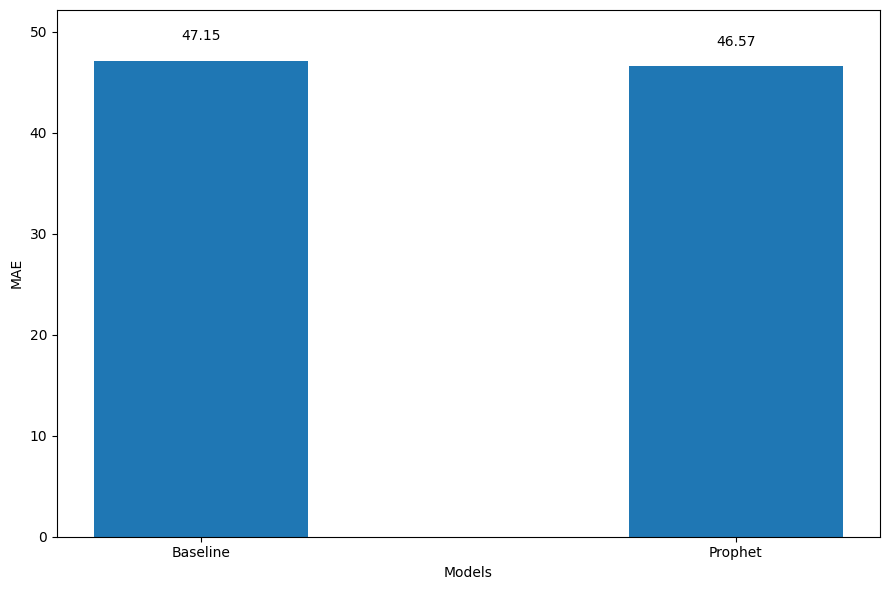

In [15]:
fig, ax = plt.subplots()

x = ['Baseline', 'Prophet']
y = [baseline_mae, prophet_mae]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
ax.set_ylim(0, max(y) + 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 2, s=str(round(value,2)), ha='center')

plt.tight_layout()

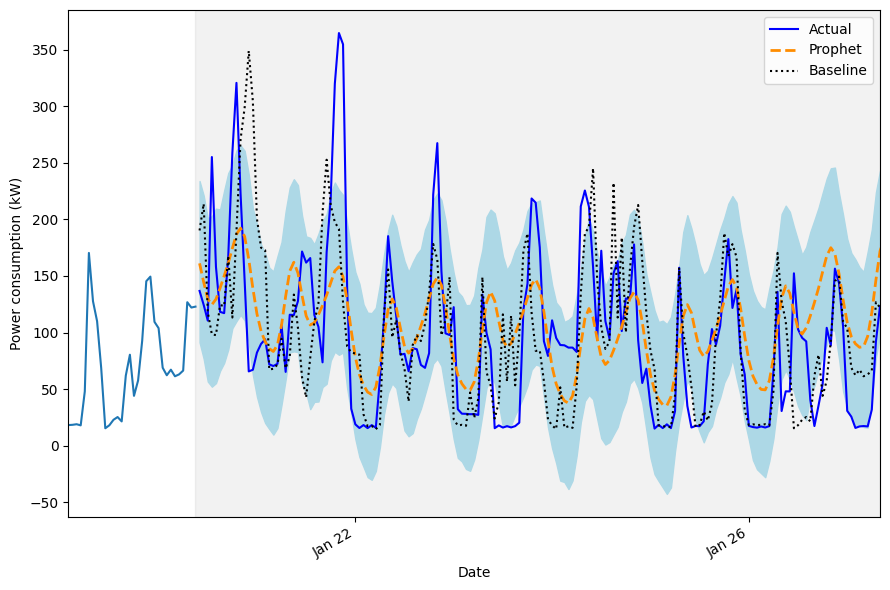

In [16]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(test['y'], 'b-', label='Actual')
ax.plot(test['yhat'], color='darkorange', ls='--', lw=2, label='Prophet')
ax.plot(test['baseline'], 'k:', label='Baseline')

ax.set_xlabel('Date')
ax.set_ylabel('Power consumption (kW)')

ax.axvspan(831, 998, color='#808080', alpha=0.1)

ax.legend(loc='best')

plt.xticks(np.arange(6, 999, 96), ['Dec 17', 'Dec 21', 'Dec 25', 'Dec 29', 'Jan 2', 'Jan 6', 'Jan 10', 'Jan 14', 'Jan 18', 'Jan 22', 'Jan 26'])

plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')

plt.xlim(800, 998)

fig.autofmt_xdate()
plt.tight_layout()

## Prophet's advanced functionalities 

### Visualizations 

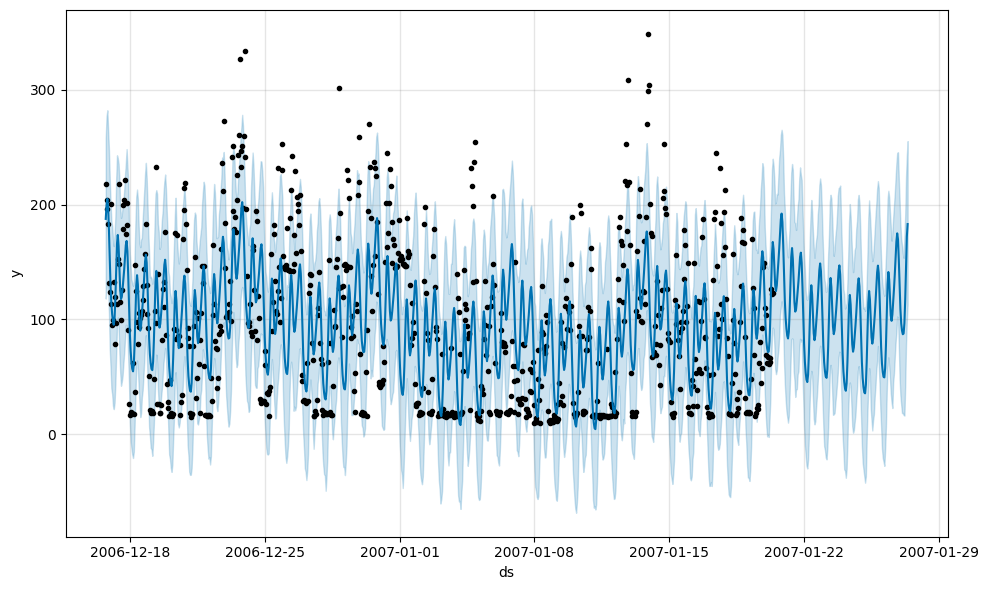

In [17]:
# Plotting predcitions
fig1 = m.plot(forecast)

#### Plot components 

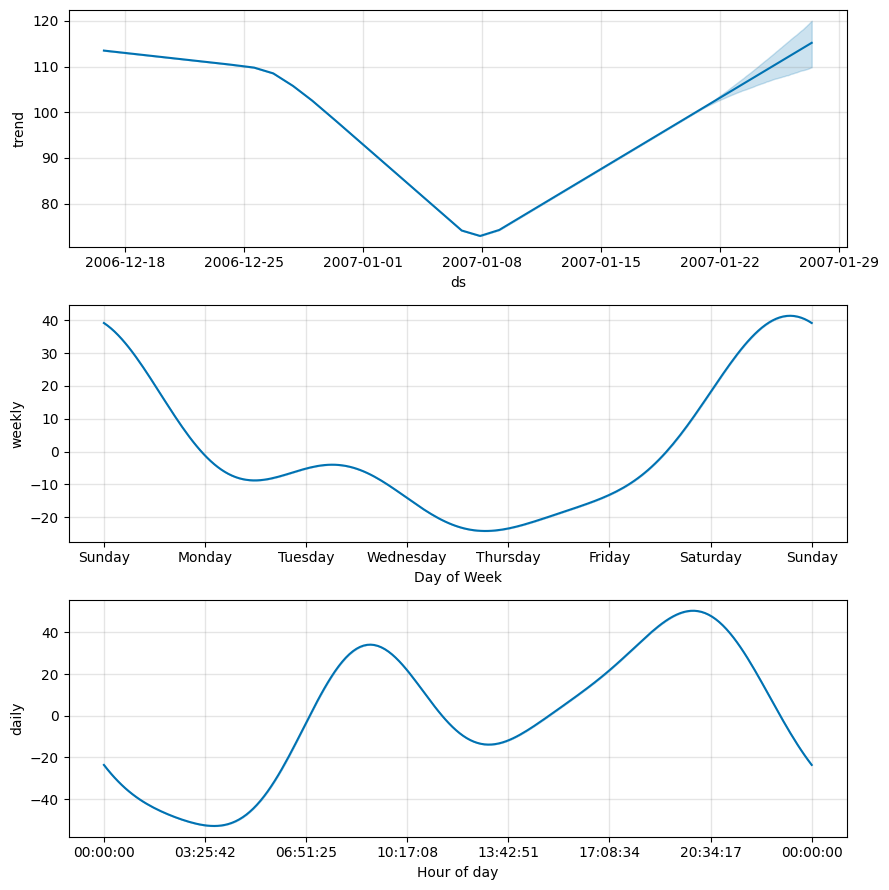

In [18]:
# components
fig2 = m.plot_components(forecast)

#### Show trend changepoints 

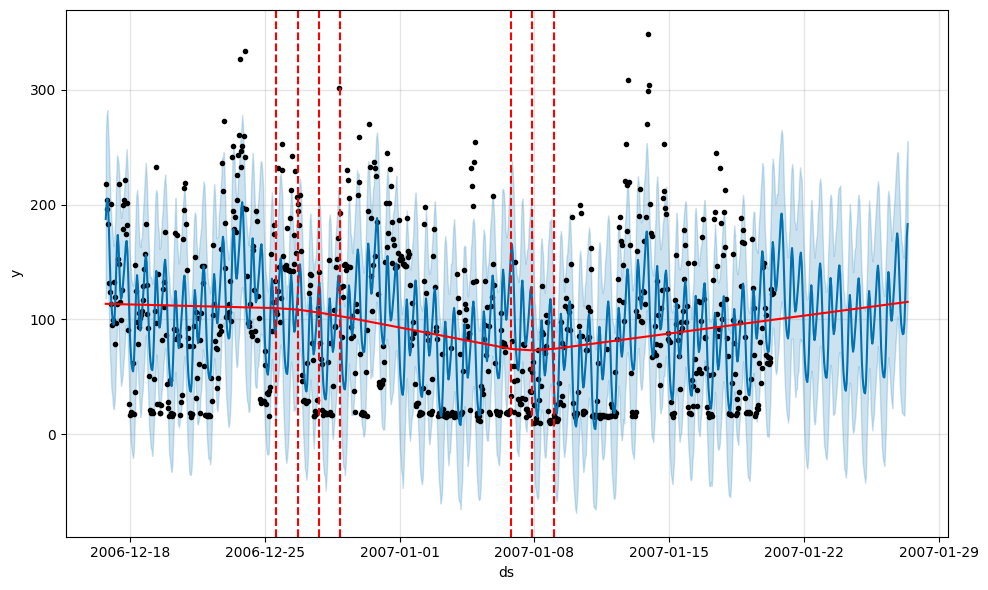

In [19]:
# Show trend changepoints
from prophet.plot import add_changepoints_to_plot

fig3 = m.plot(forecast)
a = add_changepoints_to_plot(fig3.gca(), m, forecast)

#### Plot seasonal components separately 

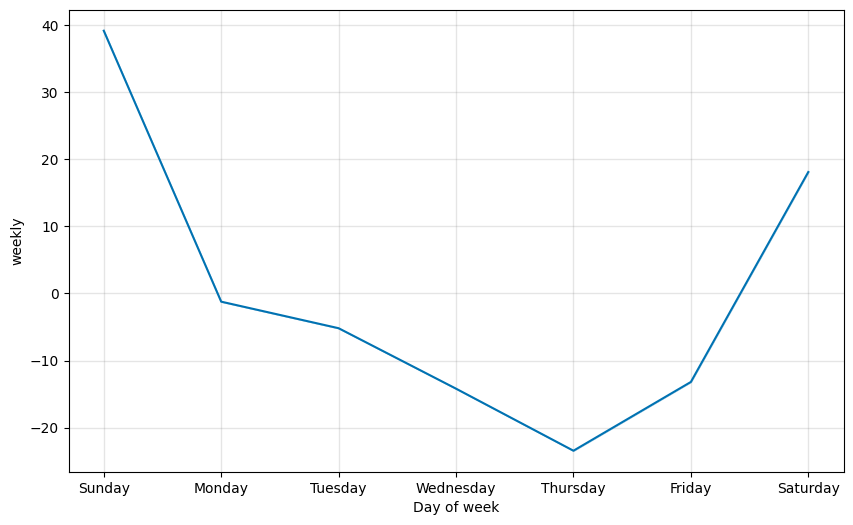

In [20]:
# separate components
from prophet.plot import plot_yearly, plot_weekly

fig4 = plot_weekly(m)

#### Tune seasonality's sensitivity 

17:04:54 - cmdstanpy - INFO - Chain [1] start processing
17:04:55 - cmdstanpy - INFO - Chain [1] done processing


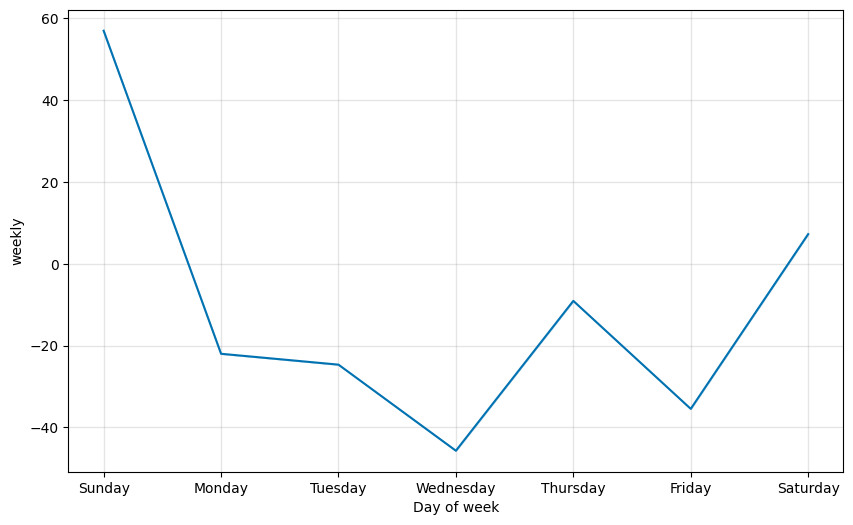

In [21]:
# Tuning the seasonality
m2 = Prophet(weekly_seasonality=20).fit(train)

fig6 = plot_weekly(m2)

### Cross-validation and performance metrics 

In [22]:
# Cross validation
from prophet.diagnostics import cross_validation

df_cv = cross_validation(m, initial='504 hours', period='84 hours', horizon = '168 hours', parallel = 'processes')
df_cv.head()

17:12:22 - cmdstanpy - INFO - Chain [1] start processing
17:12:22 - cmdstanpy - INFO - Chain [1] start processing
17:12:22 - cmdstanpy - INFO - Chain [1] done processing
17:12:22 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2007-01-09 22:00:00,30.785758,-38.393535,103.022912,111.454,2007-01-09 21:00:00
1,2007-01-09 23:00:00,3.152348,-65.734591,74.740835,189.508,2007-01-09 21:00:00
2,2007-01-10 00:00:00,-17.338653,-87.598560,53.844166,27.360,2007-01-09 21:00:00
3,2007-01-10 01:00:00,-28.502854,-95.927331,39.996110,17.178,2007-01-09 21:00:00
4,2007-01-10 02:00:00,-34.884531,-107.094375,35.077873,18.650,2007-01-09 21:00:00


In [24]:
from prophet.diagnostics import performance_metrics

df_perf = performance_metrics(df_cv, rolling_window = 0)
df_perf.head(15)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 01:00:00,5561.550151,74.575801,74.303721,0.540488,0.540488,0.784559,0.5
1,0 days 02:00:00,23097.740513,151.979408,146.719987,0.742133,0.742133,1.301409,0.0
2,0 days 03:00:00,1361.894445,36.903854,35.819844,0.930815,0.930815,1.128610,1.0
3,0 days 04:00:00,1151.950922,33.940402,30.208626,1.404549,1.404549,1.080984,1.0
4,0 days 05:00:00,1522.131043,39.014498,33.444017,1.503524,1.503524,1.073286,1.0
5,0 days 06:00:00,2165.656228,46.536612,45.236689,2.003036,2.003036,1.160134,1.0
6,0 days 07:00:00,2289.574593,47.849499,44.241400,1.980195,1.980195,1.117758,1.0
7,0 days 08:00:00,3712.847425,60.933139,60.933016,1.829656,1.829656,1.221163,1.0
8,0 days 09:00:00,2033.062723,45.089497,34.832110,0.893792,0.893792,1.026636,1.0
9,0 days 10:00:00,6319.099172,79.492762,77.086920,0.666674,0.666674,1.179760,0.5


In [25]:
df_perf = performance_metrics(df_cv, rolling_window = 1)
df_perf.head(15)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,8018.191693,89.544356,70.693376,0.983594,0.753441,1.16293,0.616071


In [26]:
df_perf = performance_metrics(df_cv, rolling_window = 0.1)
df_perf.head(15)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 17:00:00,11447.253677,106.991839,86.957770,1.162882,0.769787,1.240991,0.590909
1,0 days 18:00:00,10644.335545,103.171389,82.252702,1.191543,0.782753,1.257410,0.636364
2,0 days 19:00:00,10140.138180,100.698253,80.245515,1.190245,0.769787,1.265481,0.636364
3,0 days 20:00:00,10298.179143,101.479945,81.731876,1.163486,0.769787,1.275344,0.606061
4,0 days 21:00:00,10367.922944,101.822998,82.786933,1.112117,0.769787,1.265447,0.606061
5,0 days 22:00:00,10451.809938,102.234094,83.086610,1.031618,0.769787,1.235709,0.575758
6,0 days 23:00:00,10400.657596,101.983614,82.459962,0.936171,0.732553,1.198142,0.575758
7,1 days 00:00:00,10439.098863,102.171908,82.502942,0.849399,0.732553,1.170573,0.545455
8,1 days 01:00:00,11015.610128,104.955277,84.456117,0.797164,0.732553,1.160635,0.515152
9,1 days 02:00:00,11584.423077,107.630958,86.707879,0.795781,0.732553,1.164121,0.500000


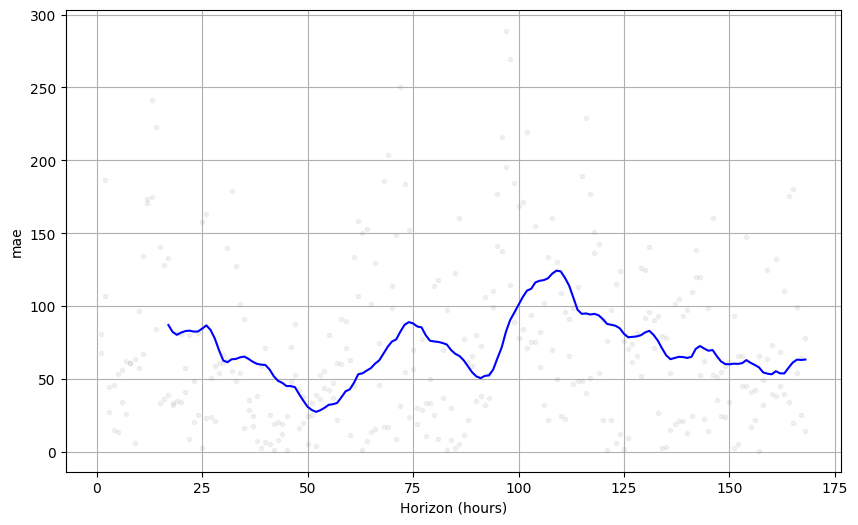

In [27]:
from prophet.plot import plot_cross_validation_metric

fig7 = plot_cross_validation_metric(df_cv, metric = 'mae')

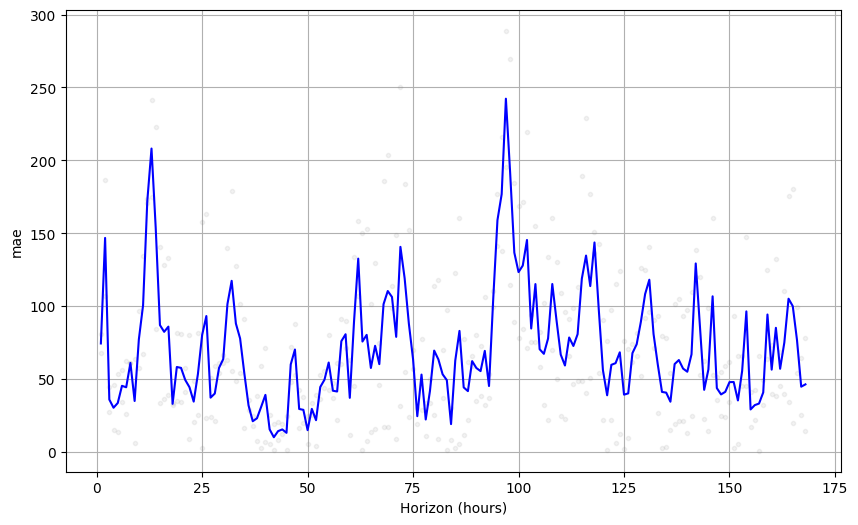

In [29]:
fig8 = plot_cross_validation_metric(df_cv, metric = 'mae', rolling_window=0)

### Hyperparameter tuning 

In [37]:
# Change hyperparameters
from itertools import product

param_grid = {'changepoint_prior_scale' : [0.001, 0.01, 0.5],
              'seasonality_prior_scale' : [0.01, 0.1, 1.0, 10.0]}

all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

maes = []

for params in all_params:
    m = Prophet(**params).fit(train)
    df_cv = cross_validation(m, initial='504 hours', period='84 hours', horizon = '168 hours', parallel = 'processes')
    df_p = performance_metrics(df_cv, rolling_window = 1)
    maes.append(df_p['mae'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes

tuning_results

17:26:45 - cmdstanpy - INFO - Chain [1] start processing
17:26:45 - cmdstanpy - INFO - Chain [1] done processing
17:26:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:26:45 - cmdstanpy - INFO - Chain [1] start processing
17:26:46 - cmdstanpy - INFO - Chain [1] done processing
17:26:48 - cmdstanpy - INFO - Chain [1] start processing
17:26:48 - cmdstanpy - INFO - Chain [1] start processing
17:26:48 - cmdstanpy - INFO - Chain [1] done processing
17:26:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:26:48 - cmdstanpy - INFO - Chain [1] done processing
17:26:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:26:48 - cmdstanpy - INFO - Chain [1] start processing
17:26:48 - cmdstanpy - 

,changepoint_prior_scale,seasonality_prior_scale,mae
0,0.001,0.01,54.609913
1,0.001,0.10,53.013355
2,0.001,1.00,53.239080
3,0.001,10.00,53.348743
4,0.010,0.01,56.381313
5,0.010,0.10,54.685216
6,0.010,1.00,55.456725
7,0.010,10.00,55.949644
8,0.500,0.01,63.796078
9,0.500,0.10,80.440614


In [38]:
best_params = all_params[np.argmin(maes)]
best_params

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}

In [36]:
for d in product(*param_grid.values()):

    print(d)

(0.001, 0.01)
(0.001, 0.1)
(0.001, 1.0)
(0.001, 10.0)
(0.01, 0.01)
(0.01, 0.1)
(0.01, 1.0)
(0.01, 10.0)
(0.5, 0.01)
(0.5, 0.1)
(0.5, 1.0)
(0.5, 10.0)


In [35]:
param_grid.values()

dict_values([[0.001, 0.01, 0.5], [0.01, 0.1, 1.0, 10.0]])